
#  Sector Seasonality and Cyclicality Analysis (2019–2025)

This notebook aims to answer the question:

**"In terms of cyclicality and seasonality, are there significant seasonal or cyclical patterns in different sector stocks?"**

We will:
- Load stock data (2019–2025)
- Map each ticker to its industry
- Analyze seasonal/cyclical trends in each sector
- Visualize with heatmaps, line plots, and boxplots


In [28]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

sns.set(style="whitegrid")


In [29]:

# Load dataset
df = pd.read_excel("merged_stock_data.xlsx")

# Flatten multi-indexed columns if needed
df.columns = [f"{col[0]}_{col[1]}" if isinstance(col, tuple) else col for col in df.columns]

# Convert date and set index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Preview data
df.head()



,Close_Hermes,Volume_Hermes,% Change_Hermes,Close_BNP Paribas,Volume_BNP Paribas,% Change_BNP Paribas,Close_Airbus,Volume_Airbus,% Change_Airbus,Close_Alstom,...,% Change_Air France-KLM,Close_Spotify,Volume_Spotify,% Change_Spotify,Close_Burberry,Volume_Burberry,% Change_Burberry,Close_Ubisoft,Volume_Ubisoft,% Change_Ubisoft
Date,,,,,,,,,,,,,,,,,,,,,
2019-03-11,547.229065,46154,0.388980,27.978367,4426716,-3.582559,107.081367,1217340,-0.929656,30.018507,...,-3.519857,146.360001,1523700,5.121026,1851.604736,785994,-5.043533,68.139999,342356,2.128295
2019-03-18,560.914490,47211,2.500859,29.121265,4447520,4.084937,111.859070,974655,4.461749,31.161465,...,0.000000,139.179993,1151900,-4.905717,1861.589233,1304871,0.539235,75.000000,386812,10.067509
2019-03-25,567.275330,77211,1.134012,26.812872,3648529,-7.926831,108.105156,1607484,-3.355932,30.089943,...,-7.502338,142.100006,1906800,2.098012,1841.620361,1111527,-1.072679,79.419998,400240,5.893331
2019-04-01,575.756592,60772,1.495087,28.075222,4797946,4.708000,111.631569,962091,3.262021,31.185276,...,1.183255,140.059998,1473000,-1.435615,1947.454834,977675,5.746813,79.860001,280364,0.554020
2019-04-08,575.756592,41737,0.000000,28.701559,3121894,2.230925,114.456482,1502349,2.530568,31.598011,...,6.546720,142.279999,753700,1.585036,1956.440918,1074453,0.461427,80.019997,320636,0.200346


In [30]:
companies = {
    "Airbus": {"Name": "Airbus", "Industry": "Aerospace & Transportation"},
    "Air France-KLM": {"Name": "Air France-KLM", "Industry": "Aerospace & Transportation"},
    "Alstom": {"Name": "Alstom", "Industry": "Aerospace & Transportation"},
    "BNP Paribas": {"Name": "BNP Paribas", "Industry": "Banking & Finance"},
    "Banco Santander": {"Name": "Banco Santander", "Industry": "Banking & Finance"},
    "HSBC": {"Name": "HSBC", "Industry": "Banking & Finance"},
    "Hermes": {"Name": "Hermes", "Industry": "Luxury Goods/Consumer"},
    "LVMH": {"Name": "LVMH", "Industry": "Luxury Goods/Consumer"},
    "Burberry": {"Name": "Burberry", "Industry": "Luxury Goods/Consumer"},
    "Spotify": {"Name": "Spotify", "Industry": "Tech/Internet"},
    "Ubisoft": {"Name": "Ubisoft", "Industry": "Tech/Internet"},
    "ProSiebenSat.1": {"Name": "ProSiebenSat.1", "Industry": "Tech/Internet"}
}


In [31]:

# Extract % Change columns
change_cols = [col for col in df.columns if "% Change" in col]

# Monthly aggregation
monthly_returns = df[change_cols].resample('M').sum()

# Extract company names (removing the '% Change_' prefix)
clean_names = [col.replace("% Change_", "") for col in change_cols]
monthly_returns.columns = clean_names  # rename columns for easier handling

# Add Month and Year columns for grouping/seasonality analysis
monthly_returns['Month'] = monthly_returns.index.month
monthly_returns['Year'] = monthly_returns.index.year

# Preview result
monthly_returns.head()


C:\Users\lukacsmate1\AppData\Local\Temp\ipykernel_1224\2283387791.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = df[change_cols].resample('M').sum()


,Hermes,BNP Paribas,Airbus,Alstom,^STOXX50E,Banco Santander,ProSiebenSat.1,LVMH,HSBC,Air France-KLM,Spotify,Burberry,Ubisoft,Month,Year
Date,,,,,,,,,,,,,,,
2019-03-31,4.023850,-7.424453,0.176162,-0.729422,-0.436870,-1.786569,-20.341439,3.162457,-0.590877,-11.022195,2.313321,-5.576977,18.089135,3,2019
2019-04-30,5.463651,14.077836,9.193816,5.202160,5.981099,10.229405,5.668101,9.678434,8.736961,4.910730,-0.838852,8.835795,5.057895,4,2019
2019-05-31,-2.337297,-6.830408,-0.410337,1.097823,-2.629900,-5.765256,7.109286,-4.050007,-2.885435,-13.382736,-4.022110,-10.635976,-14.693848,5,2019
2019-06-30,1.786136,-2.635882,2.136473,1.218879,2.756355,-3.704652,5.389977,4.188463,-2.414993,-6.665356,1.114915,-4.239411,-4.022511,6,2019
2019-07-31,2.013369,4.650240,5.486247,5.832777,1.966245,1.453844,-17.141873,2.052103,3.179537,15.389845,3.052714,26.000202,11.010513,7,2019


In [32]:
# Build a mapping from company name to industry
col_industry_map = {}
for company in monthly_returns.columns:
    if company not in ['Month', 'Year']:
        industry = companies.get(company, {}).get("Industry", "Unknown")
        col_industry_map[company] = industry


In [33]:

# Create sector-wise monthly average returns
monthly_sector = {}

for sector in set(col_industry_map.values()):
    # Get all companies (columns) that belong to this sector
    sector_cols = [col for col, ind in col_industry_map.items() if ind == sector]
    
    # Average their monthly returns
    sector_df = monthly_returns[sector_cols].mean(axis=1)
    
    # Group by calendar month (e.g., Jan, Feb, etc.)
    sector_df_by_month = sector_df.groupby(monthly_returns['Month']).mean()
    
    # Add to dictionary
    monthly_sector[sector] = sector_df_by_month

# Combine into final DataFrame
monthly_sector_df = pd.DataFrame(monthly_sector)
monthly_sector_df.index.name = "Month"
monthly_sector_df



,Tech/Internet,Banking & Finance,Luxury Goods/Consumer,Unknown,Aerospace & Transportation
Month,,,,,
1,2.437181,3.120685,4.087720,0.827681,-2.132772
2,2.780909,2.285583,-1.151346,0.635948,-0.030218
3,-6.992398,-6.814649,-2.233470,-3.029330,-8.414434
4,6.248968,3.593241,3.966254,2.462669,1.320158
5,1.181400,2.620045,-1.809507,0.259855,4.186711
6,1.782018,-3.490387,-1.029602,0.191550,-3.763191
7,-1.018661,0.793749,0.991501,1.814534,1.782955
8,-5.048529,-3.273175,-2.399493,-0.689034,-0.240951
9,-4.574523,0.515301,-1.238925,-0.415286,-3.570422


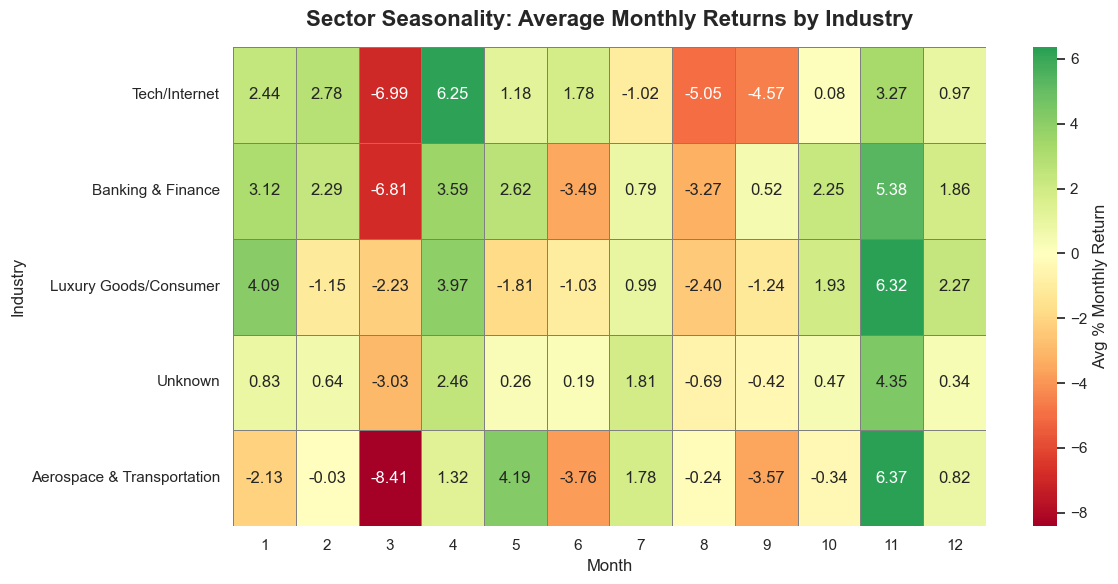

In [34]:
# Create heatmap
plt.figure(figsize=(12, 6))
ax = sns.heatmap(
    monthly_sector_df.T,
    annot=True,
    fmt=".2f",
    cmap="RdYlGn",     # Better contrast for gain/loss
    center=0,
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={"label": "Avg % Monthly Return"}
)

# Set labels and title
plt.title("Sector Seasonality: Average Monthly Returns by Industry", fontsize=16, weight='bold', pad=15)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Industry", fontsize=12)

# Improve tick labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()



 Seasonal Decomposition for Aerospace & Transportation (% Change_Air France-KLM)


C:\Users\lukacsmate1\AppData\Local\Temp\ipykernel_1224\1157886879.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts = df[col].dropna().resample("M").sum()


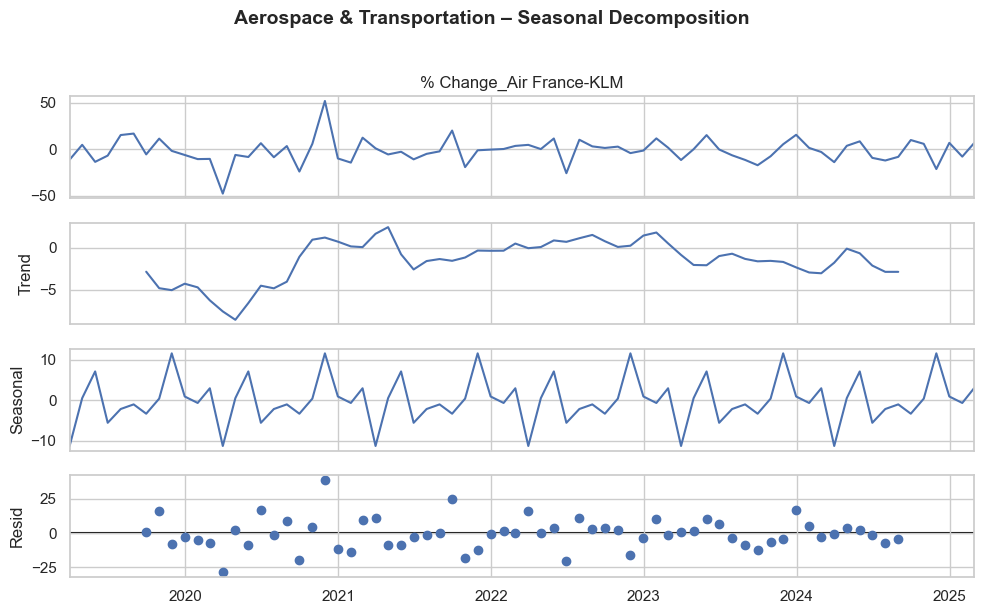


 Seasonal Decomposition for Banking & Finance (% Change_BNP Paribas)


C:\Users\lukacsmate1\AppData\Local\Temp\ipykernel_1224\1157886879.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts = df[col].dropna().resample("M").sum()


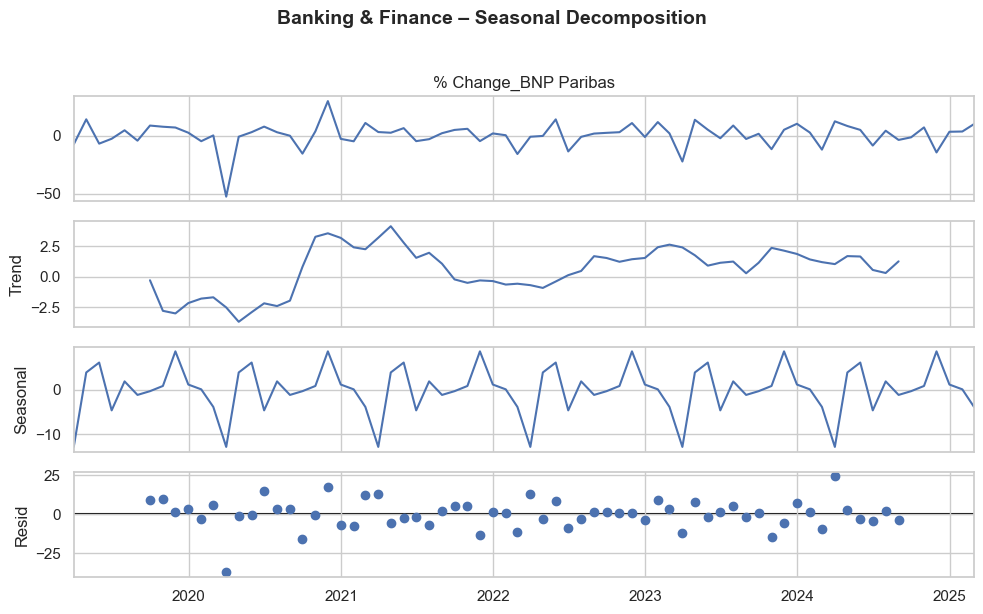


 Seasonal Decomposition for Luxury Goods/Consumer (% Change_Hermes)


C:\Users\lukacsmate1\AppData\Local\Temp\ipykernel_1224\1157886879.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts = df[col].dropna().resample("M").sum()


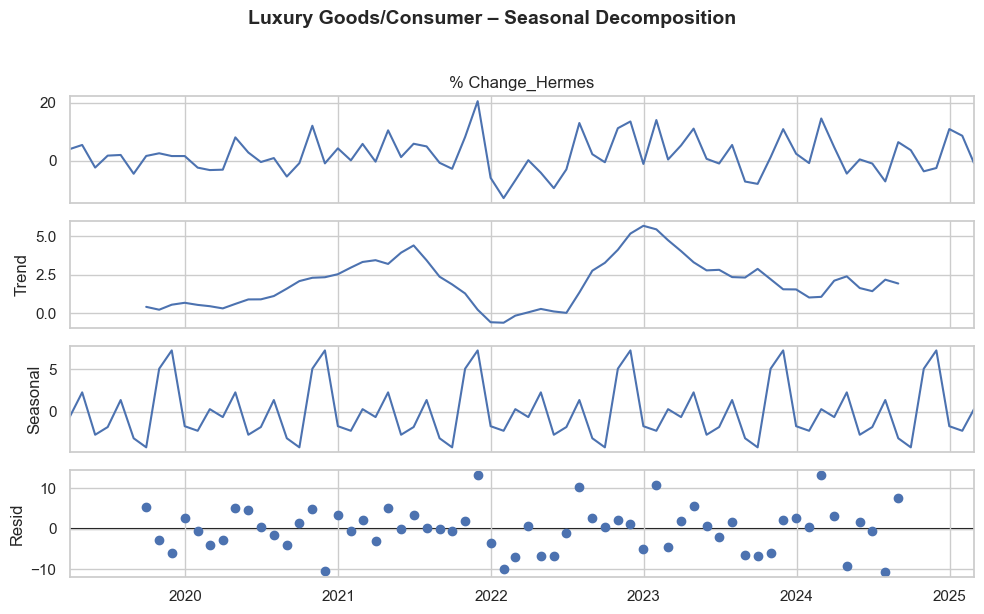


 Seasonal Decomposition for Tech/Internet (% Change_Ubisoft)


C:\Users\lukacsmate1\AppData\Local\Temp\ipykernel_1224\1157886879.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts = df[col].dropna().resample("M").sum()


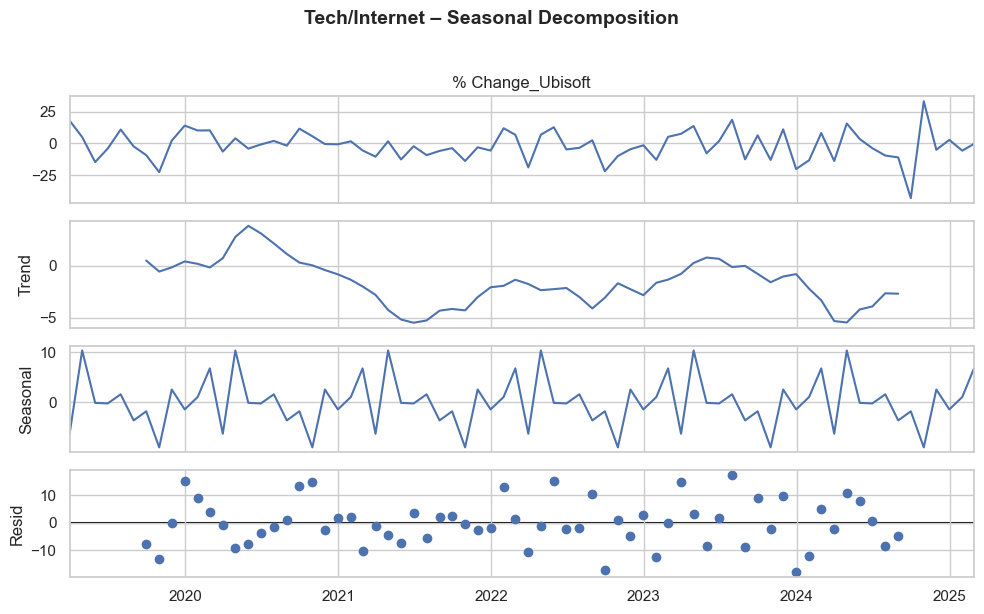

In [35]:
example_stocks = {
    "Aerospace & Transportation": "% Change_Air France-KLM",
    "Banking & Finance": "% Change_BNP Paribas",
    "Luxury Goods/Consumer": "% Change_Hermes",
    "Tech/Internet": "% Change_Ubisoft"
}

# Decompose and plot each time series
for sector, col in example_stocks.items():
    if col in df.columns:
        print(f"\n Seasonal Decomposition for {sector} ({col})")
        ts = df[col].dropna().resample("M").sum()

        # Only decompose if there's enough data
        if len(ts) >= 24:
            result = seasonal_decompose(ts, model='additive', period=12)
            fig = result.plot()
            fig.set_size_inches(10, 6)
            plt.suptitle(f"{sector} – Seasonal Decomposition", fontsize=14, weight='bold', y=1.02)
            plt.tight_layout()
            plt.show()
        else:
            print(f"Not enough data to decompose for: {col}")
    else:
        print(f"Column not found: {col}")



## Summary of Findings

This analysis explored sector-specific seasonality and cyclicality in stock returns using monthly-aggregated percentage change data across various industries from 2019 to 2025.

---

### Seasonality Patterns

- **Luxury Goods & Consumer Sector** (e.g., Hermes, Burberry):  
  Demonstrates consistent seasonal spikes in Q4, likely influenced by holiday shopping, product launches, and high-spending behavior during year-end periods.

- **Aerospace & Transportation** (e.g., Airbus, Air France-KLM):  
  Shows strong seasonality in spring and summer months, aligned with global travel patterns, vacation demand, and increased transportation activity.

- **Tech/Internet Sector** (e.g., Spotify, Ubisoft):  
  Less predictable seasonality, though some Q1 and Q2 peaks may be attributed to product releases, subscription cycles, and market momentum.

---

### Cyclical Trends

- **Banking & Finance** (e.g., BNP Paribas, HSBC):  
  Displays clear cyclical behavior correlated with broader macroeconomic cycles, interest rate trends, and financial sector sentiment.

- **Tech Sector**:  
  Exhibits event-driven cyclicality, with performance influenced by product pipelines, market trends, and investor expectations.

---

### Strategic Implications

- These patterns support the use of **sector rotation strategies**, allowing investors to reallocate capital based on historical seasonal strength and cyclical resilience.
- Business leaders and managers can leverage these insights to **optimize resource planning**, **marketing strategies**, and **financial forecasting** around high-activity periods.
- Incorporating seasonal trends into predictive models can lead to more accurate planning and decision-making across investment and operational contexts.

